## Perform SHAP analysis on XGBoost dataset

In [20]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations
from src.utils.directories import get_parent_directory
from src.models.shapely_test import shap_plot, plot_shap_waterfall

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html



In [21]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

In [22]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/2706_time.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

In [23]:
global_pkl = os.path.join(parent_dir, "data/processed/Mashayek2022/input_microstructure.pkl")
global_df = pd.read_pickle(global_pkl)
global_df = global_df.rename(columns={'lat': 'latitude', 'log_N2_sort': 'log_N2'})

## With SIC and MLD
700,000 datapoints

#### Filter out where depth is smaller than MLDJ (second derivative of potential density)

In [24]:
import shap
from pickle import load
import matplotlib.pyplot as plt
import numpy as np
# =============================================================================
# Load in pickle file
# =============================================================================
filename = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/models/XGboost/SIC_xgboostMLD.sav"
# Previous pickle file returned a list so we will perform 
# multiple assignment here
model, X_train, X_test, Y_train, Y_test = load(open(filename, 'rb')) 

In [25]:
# Fit explainer for tree models to unseen data
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
# View shap values
print(shap_values)

[[-0.11209155 -0.00269836 -0.00821893 ...  0.05114024  0.04034521
  -0.00308311]
 [-0.15749985 -0.0021865  -0.0120843  ...  0.03245675 -0.10348154
  -0.00868658]
 [-0.10188986 -0.00218159 -0.00973762 ...  0.02198817 -0.11407158
  -0.00307574]
 ...
 [ 0.02960391 -0.00368992 -0.00419619 ... -0.0013208  -0.11759485
  -0.00307781]
 [-0.0899488  -0.00318419 -0.00833874 ...  0.0195798  -0.1149088
  -0.0030847 ]
 [-0.06400897 -0.00332583 -0.00140953 ... -0.00952185  0.04378126
  -0.00308539]]


In [26]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']
ystringlist_all_SIC = ['log_eps']

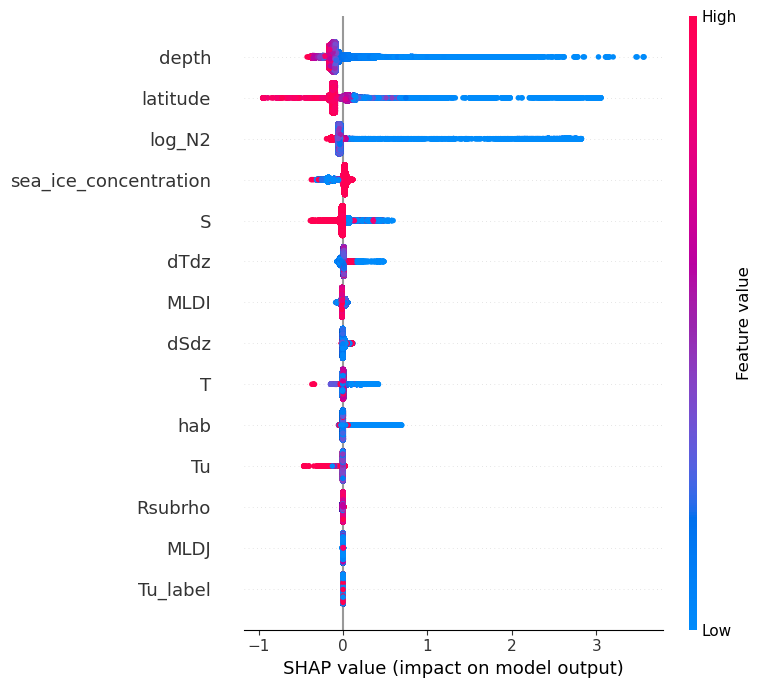

In [27]:
shap.summary_plot(shap_values, feature_names=xstringlist_all_SIC, features=X_test) # Use training set features)

## PAttern: where diffusive convection is happening, higher in feature importance, lowering predictions of epislon


## deep at pole, log_N2 instead of depth

                             31962
depth                    18.000000
hab                   -3342.000000
S                        29.316871
T                        -1.587918
dSdz                      0.021631
dTdz                      0.002004
log_N2                   -3.539578
Tu_label                 10.000000
MLDJ                     18.000000
MLDI                    264.000000
Rsubrho                   0.001500
sea_ice_concentration     0.960000
latitude                 89.047000
Tu                      -45.085956


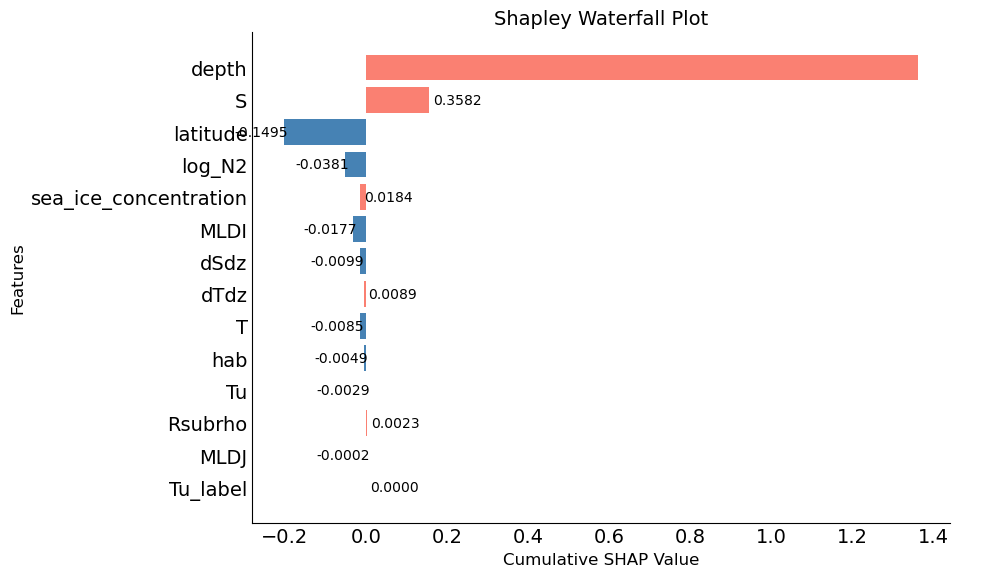

In [195]:
plot_shap_waterfall(X_test, shap_values, 182)

                             54954
depth                    93.000000
hab                   -3267.000000
S                        34.367803
T                        -1.342590
dSdz                      0.014090
dTdz                      0.144352
log_N2                   -3.898911
Tu_label                 10.000000
MLDJ                     89.000000
MLDI                     97.000000
Rsubrho                   0.460313
sea_ice_concentration     0.980000
latitude                 81.422968
Tu                      -69.717228


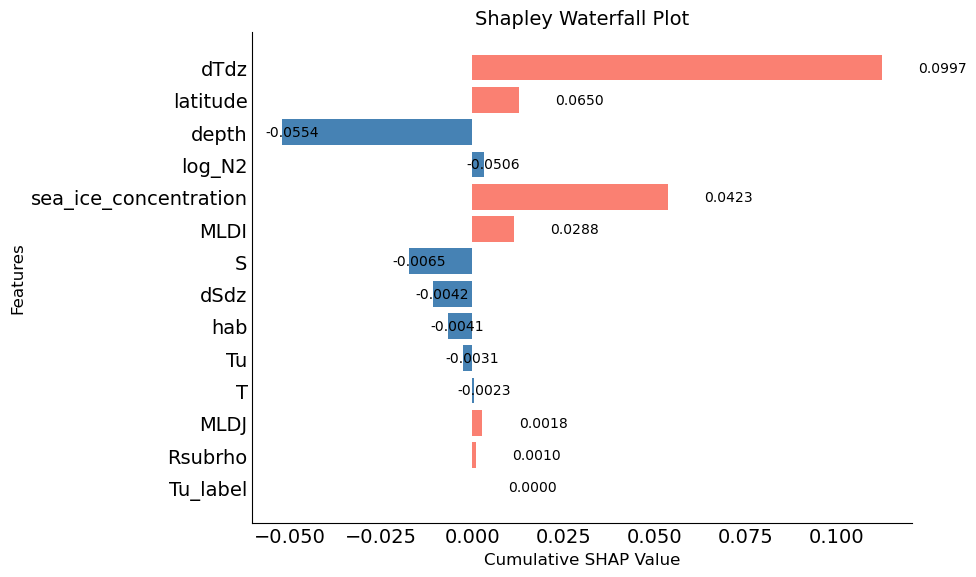

In [213]:
plot_shap_waterfall(X_test, shap_values, 1900)

                             47405
depth                    80.000000
hab                   -3280.000000
S                        34.441145
T                        -0.475856
dSdz                      0.014201
dTdz                      0.085037
log_N2                   -4.237458
Tu_label                 10.000000
MLDJ                      0.000000
MLDI                    178.000000
Rsubrho                   0.455067
sea_ice_concentration     0.990000
latitude                 80.740054
Tu                      -69.468734


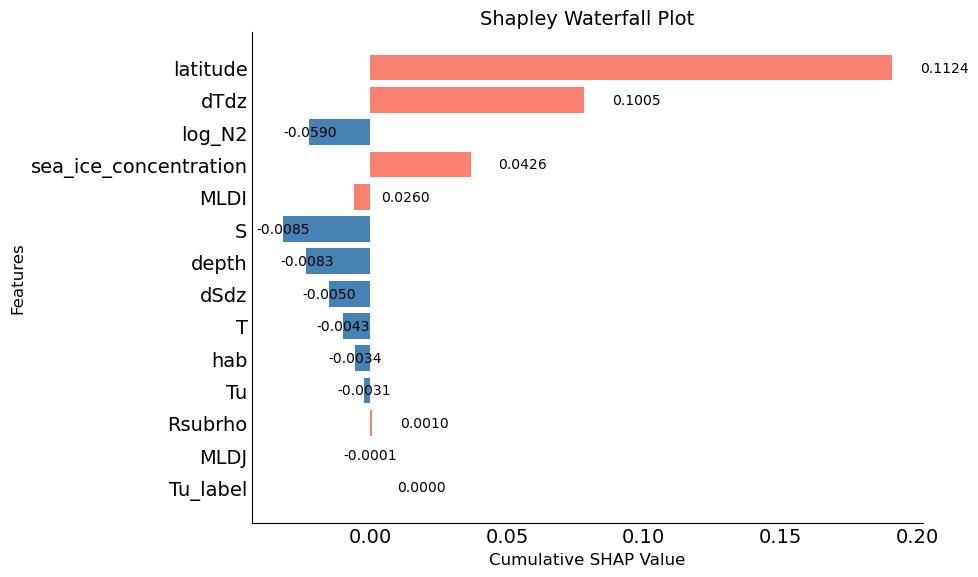

In [173]:
plot_shap_waterfall(X_test, shap_values, 158)

                             37093
depth                    63.000000
hab                   -3297.000000
S                        34.321672
T                        -1.784598
dSdz                      0.000139
dTdz                      0.000108
log_N2                   -6.026535
Tu_label                 10.000000
MLDJ                      0.000000
MLDI                     85.000000
Rsubrho                   0.050927
sea_ice_concentration     0.980000
latitude                 82.288949
Tu                      -47.915375


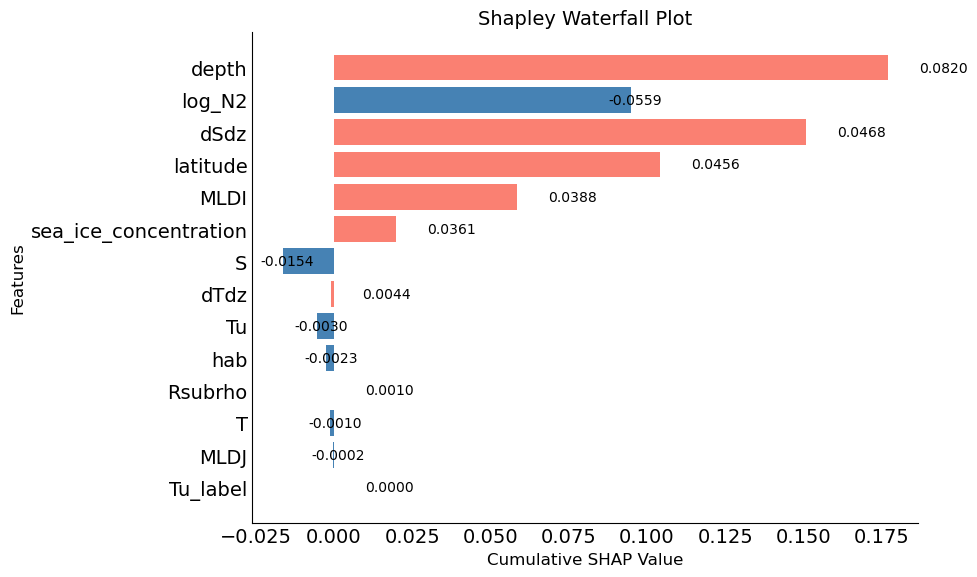

In [139]:
plot_shap_waterfall(X_test, shap_values, 120)

                            151295
depth                   257.000000
hab                   -3103.000000
S                        34.914296
T                         1.760604
dSdz                      0.001092
dTdz                      0.001965
log_N2                   -5.592652
Tu_label                 10.000000
MLDJ                      0.000000
MLDI                     63.000000
Rsubrho                   0.120881
sea_ice_concentration     0.980000
latitude                 81.922723
Tu                      -51.892537


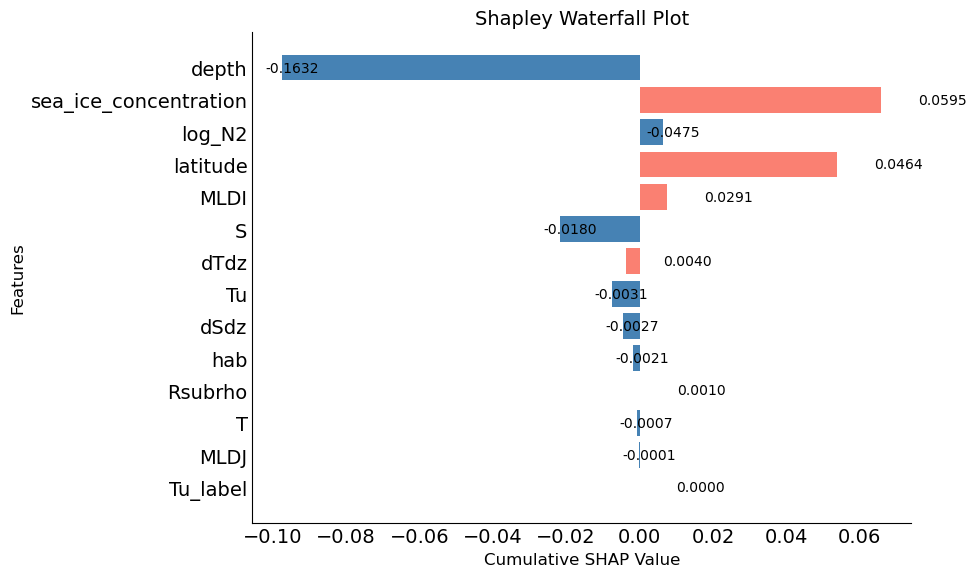

In [90]:
plot_shap_waterfall(X_test, shap_values, 70)

                            313507
depth                   186.000000
hab                   -3174.000000
S                        34.740182
T                         1.091575
dSdz                      0.000016
dTdz                     -0.005673
log_N2                   -5.744579
Tu_label                 20.000000
MLDJ                     41.000000
MLDI                    227.000000
Rsubrho                  -1.264027
sea_ice_concentration     1.000000
latitude                 87.146465
Tu                        6.651700


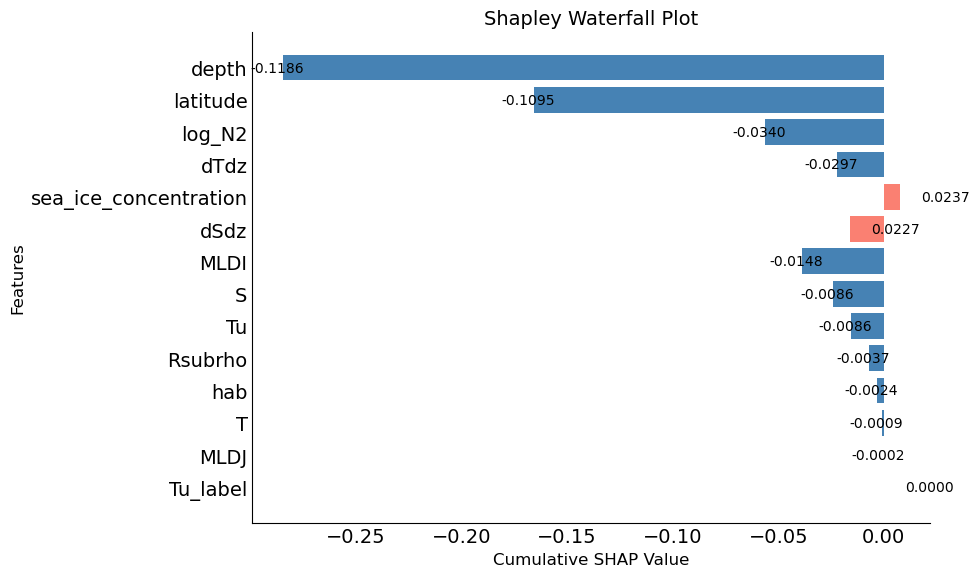

In [87]:
plot_shap_waterfall(X_test, shap_values, 67)

                             86359
depth                   246.000000
hab                   -2987.000000
S                        34.892000
T                         2.015000
dSdz                     -0.000500
dTdz                     -0.000500
log_N2                   -9.940201
Tu_label                 20.000000
MLDJ                     91.000000
MLDI                    140.000000
Rsubrho                  -0.000000
sea_ice_concentration     0.000000
latitude                 78.456367
Tu                        0.785398


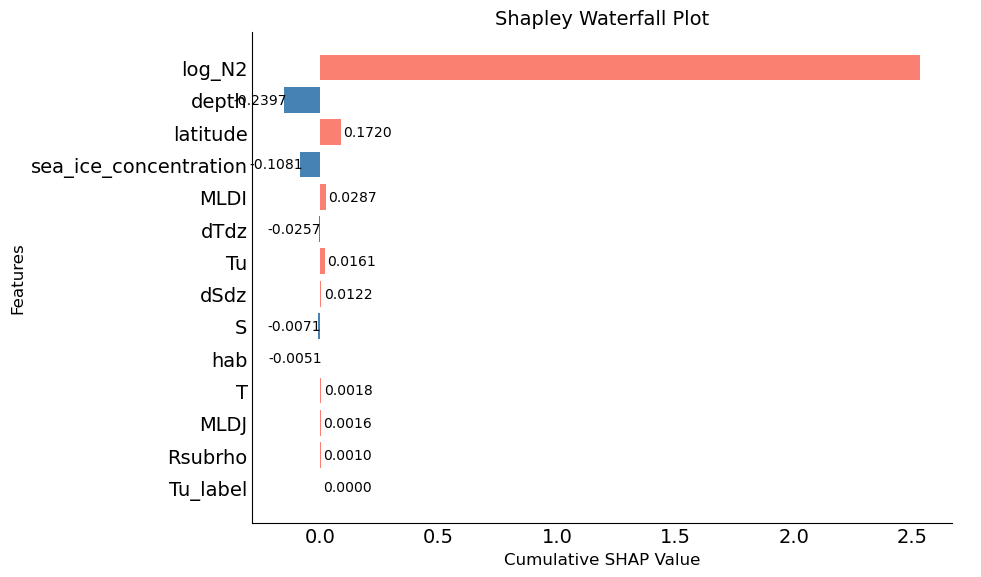

In [69]:
plot_shap_waterfall(X_test, shap_values, 47)

                             16310
depth                   207.667960
hab                   -3152.332040
S                        35.063504
T                         4.005681
dSdz                      0.001749
dTdz                      0.010472
log_N2                   -4.912867
Tu_label                 10.000000
MLDJ                      2.000000
MLDI                      2.000000
Rsubrho                   0.726866
sea_ice_concentration     0.000000
latitude                 80.449500
Tu                      -80.988980


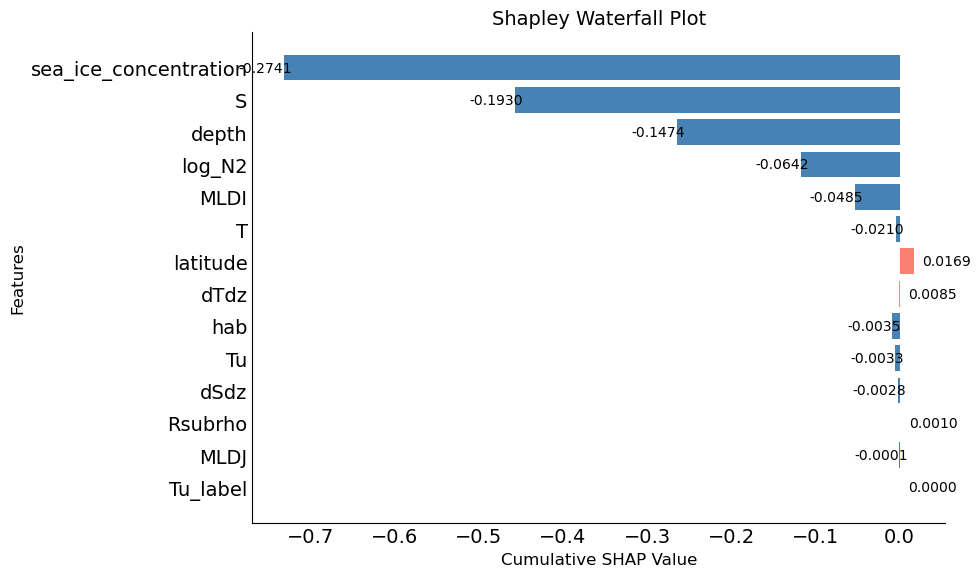

In [65]:
plot_shap_waterfall(X_test, shap_values, 45)

                             30153
depth                    85.000000
hab                   -1498.000000
S                        34.926400
T                         3.716600
dSdz                      0.000650
dTdz                     -0.016350
log_N2                  -10.363606
Tu_label                 20.000000
MLDJ                      4.000000
MLDI                     43.000000
Rsubrho                   7.235294
sea_ice_concentration     0.000000
latitude                 75.502017
Tu                       -0.039734


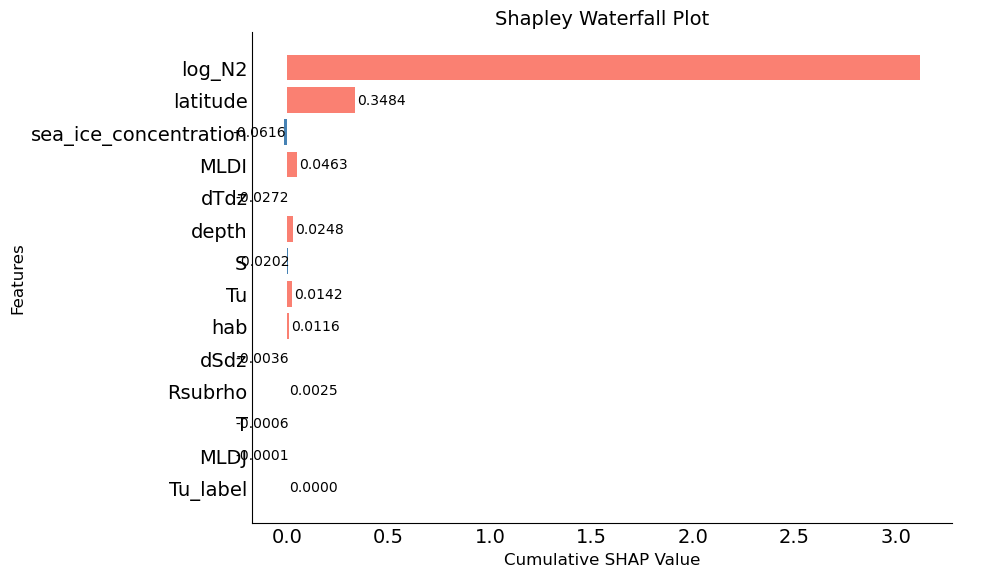

In [58]:
plot_shap_waterfall(X_test, shap_values, 38)

                              8375
depth                     4.000000
hab                   -3356.000000
S                        29.262406
T                        -1.589903
dSdz                     -0.000105
dTdz                      0.000273
log_N2                   -5.545332
Tu_label                 10.000000
MLDJ                      4.000000
MLDI                     18.000000
Rsubrho                   0.001581
sea_ice_concentration     0.960000
latitude                 89.047000
Tu                      -45.090612


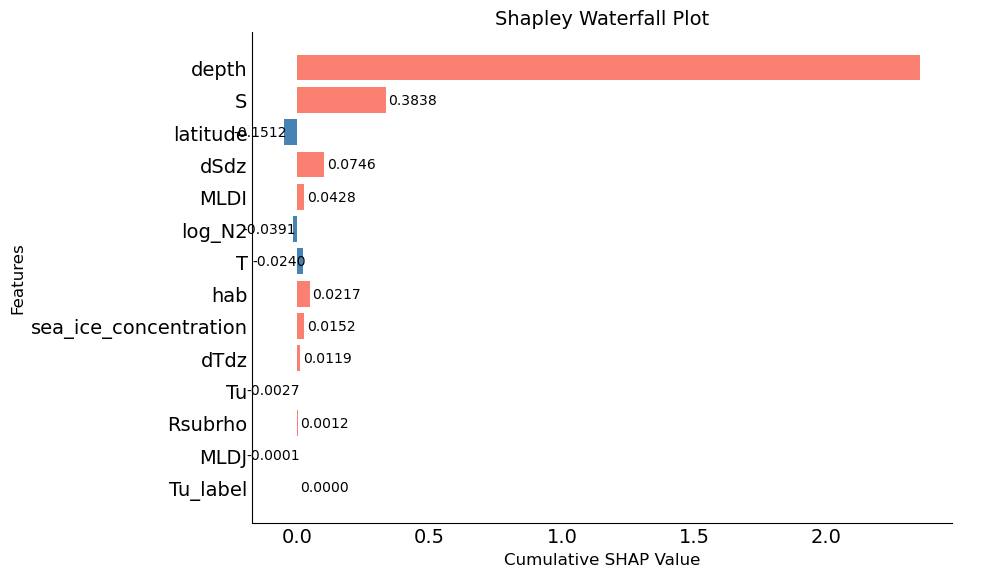

In [42]:
# Salinity
plot_shap_waterfall(X_test, shap_values, 23)

                            69800
depth                   80.000000
hab                   -118.000000
S                        0.000000
T                        0.795082
dSdz                     0.008956
dTdz                    -0.125909
log_N2                  -0.093139
Tu_label                10.000000
MLDJ                     0.000000
MLDI                    22.000000
Rsubrho                  0.000050
sea_ice_concentration    0.000000
latitude                70.040989
Tu                     -45.002843


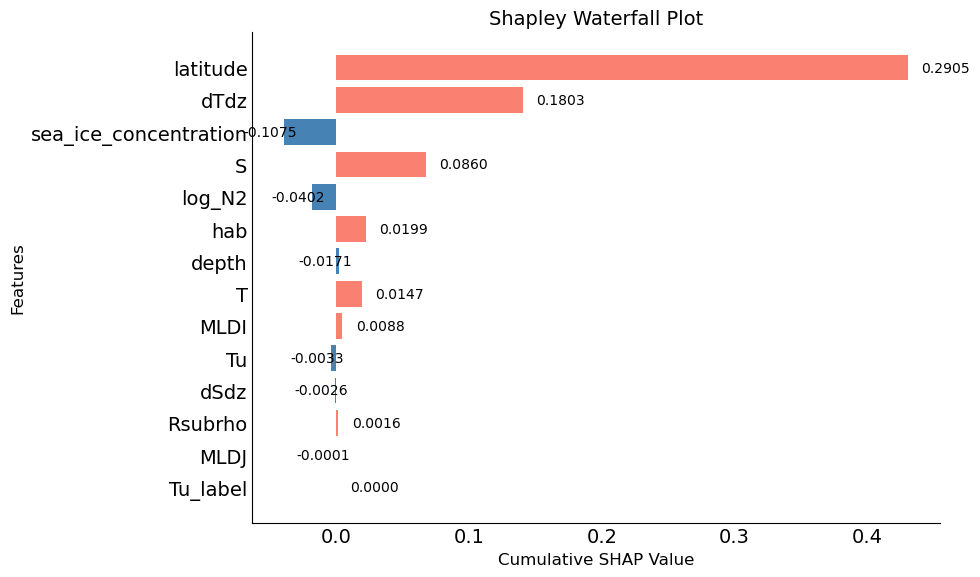

In [245]:
# Salinity
plot_shap_waterfall(X_test, shap_values, 30020)

                             53925
depth                   153.000000
hab                   -3133.000000
S                        34.404200
T                        -0.450800
dSdz                      0.005050
dTdz                     -0.001850
log_N2                  -12.868760
Tu_label                 20.000000
MLDJ                      2.000000
MLDI                     19.000000
Rsubrho                  15.875000
sea_ice_concentration     0.560000
latitude                 77.986433
Tu                       -1.219642


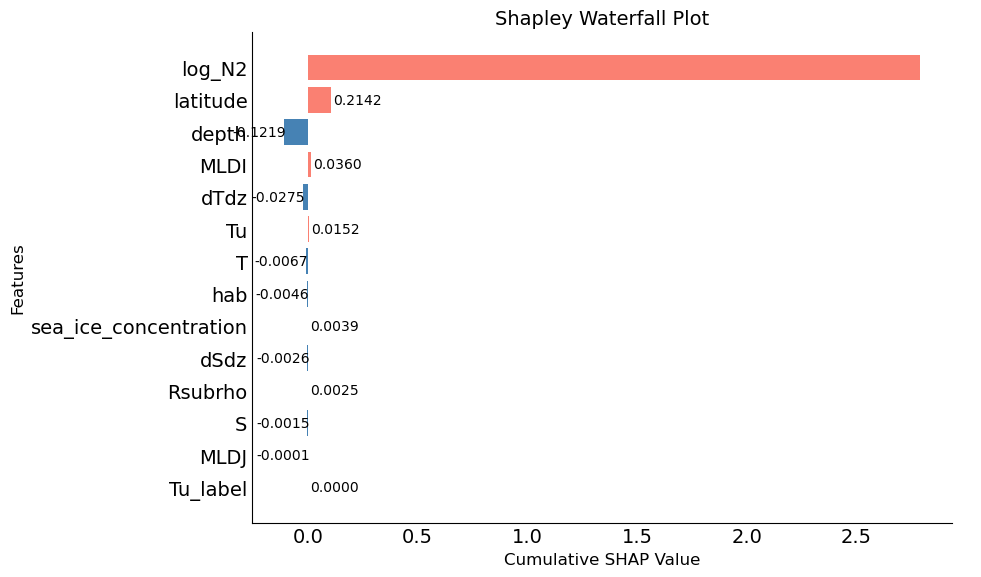

In [234]:
# Stratification
plot_shap_waterfall(X_test, shap_values, 30005)

                             87562
depth                   100.000000
hab                   -3518.000000
S                         0.000000
T                        -0.593339
dSdz                      0.001401
dTdz                     -0.031133
log_N2                   -0.068225
Tu_label                 20.000000
MLDJ                      9.000000
MLDI                     96.000000
Rsubrho                  -0.000008
sea_ice_concentration     0.000000
latitude                 72.167942
Tu                      -44.999533


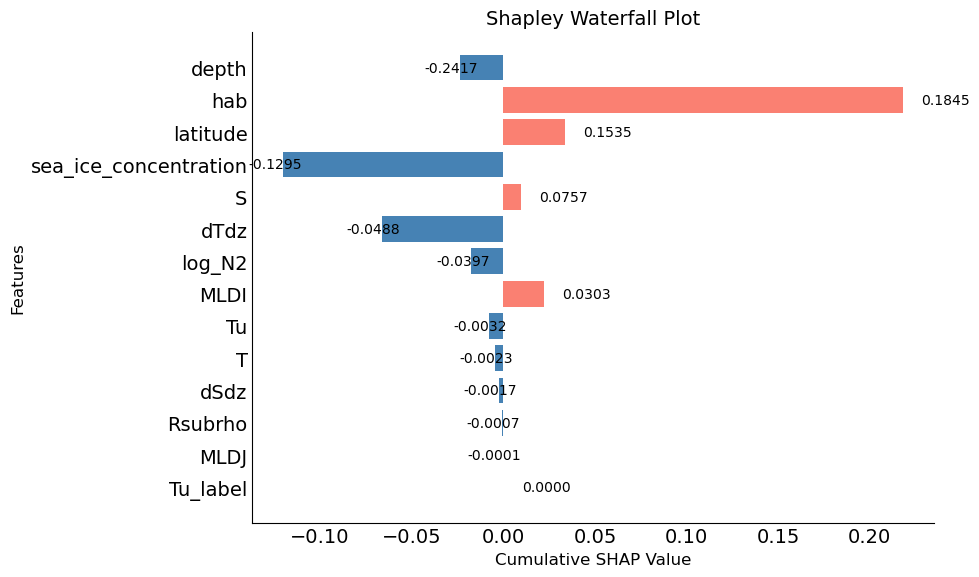

In [28]:
plot_shap_waterfall(X_test, shap_values, 9)

# high lat salty low dpeht

                            316279
depth                   187.000000
hab                   -3173.000000
S                        34.745264
T                         1.162506
dSdz                      0.000923
dTdz                      0.001307
log_N2                   -5.208347
Tu_label                 10.000000
MLDJ                      0.000000
MLDI                    257.000000
Rsubrho                   0.110790
sea_ice_concentration     0.950000
latitude                 88.293500
Tu                      -51.322045


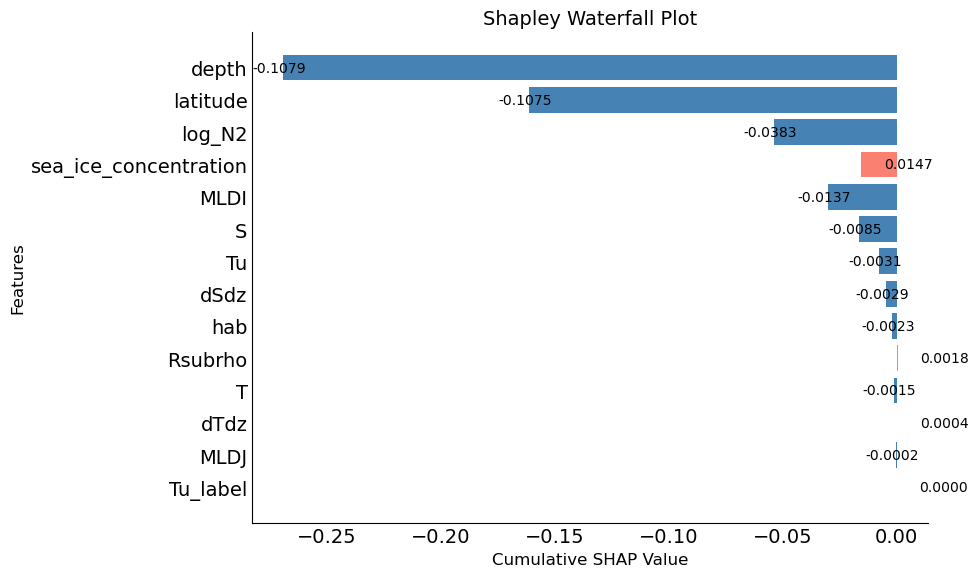

In [209]:
plot_shap_waterfall(X_test, shap_values, 163)

                             85041
depth                    50.000000
hab                   -3310.000000
S                        32.949099
T                        -1.811813
dSdz                      0.000165
dTdz                      0.000020
log_N2                   -5.729366
Tu_label                 10.000000
MLDJ                      7.000000
MLDI                     65.000000
Rsubrho                   0.010351
sea_ice_concentration     0.990000
latitude                 88.093895
Tu                      -45.593042


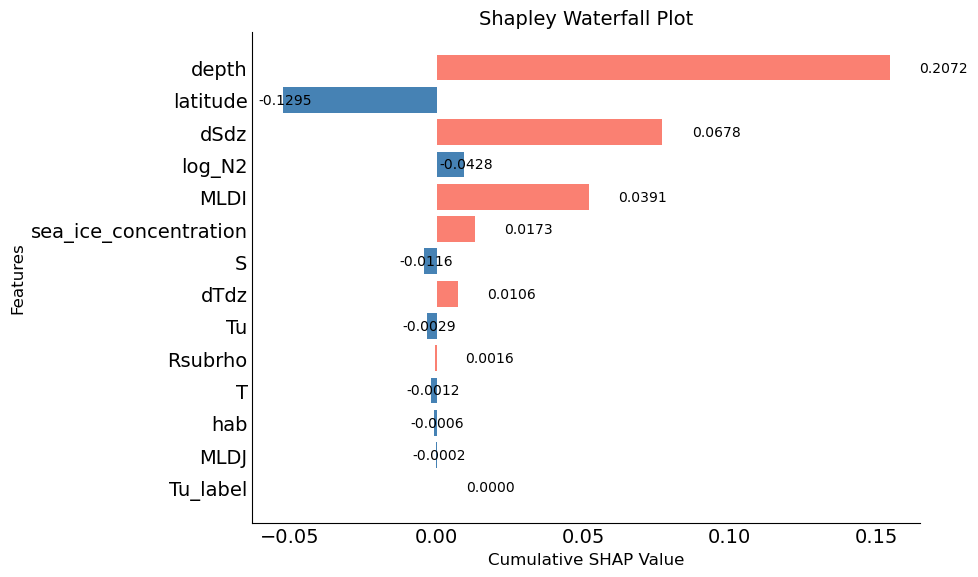

In [197]:
plot_shap_waterfall(X_test, shap_values, 31)

## Impact of depth, latitude and SIC

                             10048
depth                    11.000000
hab                   -3605.000000
S                         0.000000
T                        -0.905078
dSdz                      0.002883
dTdz                     -0.000626
log_N2                    0.018453
Tu_label                 20.000000
MLDJ                      0.000000
MLDI                    299.000000
Rsubrho                  -0.000028
sea_ice_concentration     0.000000
latitude                 72.171570
Tu                      -44.998384


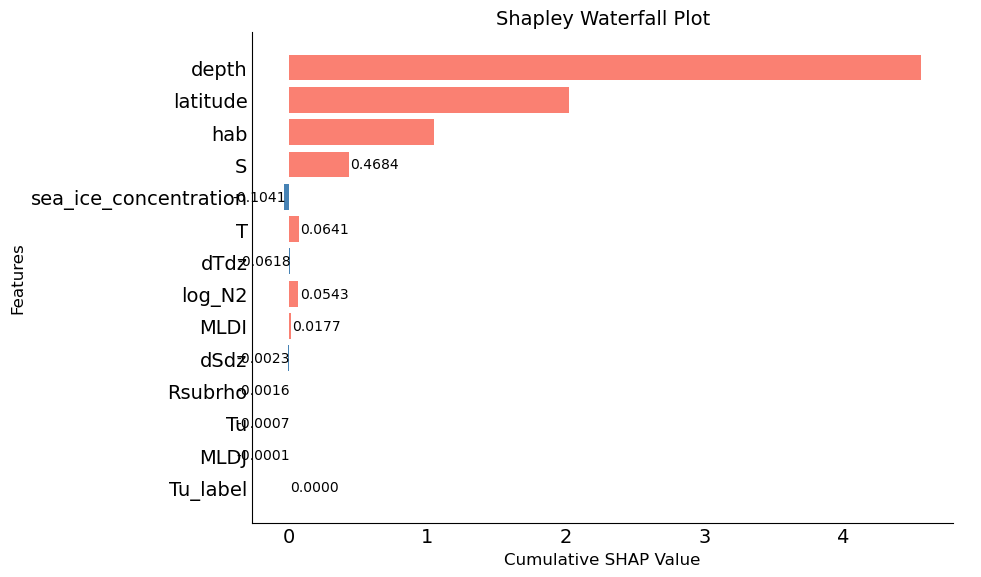

In [289]:
plot_shap_waterfall(X_test, shap_values, 7)

                            321007
depth                   190.000000
hab                   -3170.000000
S                        34.659782
T                         1.385028
dSdz                      0.006627
dTdz                      0.030685
log_N2                   -4.818913
Tu_label                 10.000000
MLDJ                     94.000000
MLDI                    315.000000
Rsubrho                   0.684496
sea_ice_concentration     0.990000
latitude                 84.572800
Tu                      -79.391467


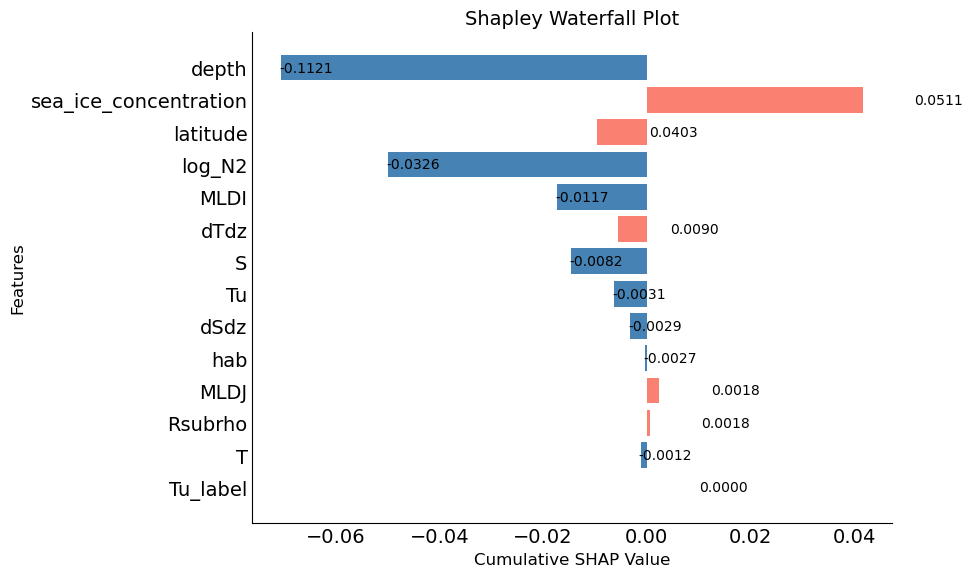

In [283]:
plot_shap_waterfall(X_test, shap_values, 0)

                             75828
depth                   216.000000
hab                   -2985.000000
S                        34.879000
T                         2.049000
dSdz                      0.001000
dTdz                      0.000000
log_N2                  -11.774722
Tu_label                 20.000000
MLDJ                     16.000000
MLDI                    112.000000
Rsubrho                   0.000000
sea_ice_concentration     0.000000
latitude                 78.072300
Tu                        1.570796


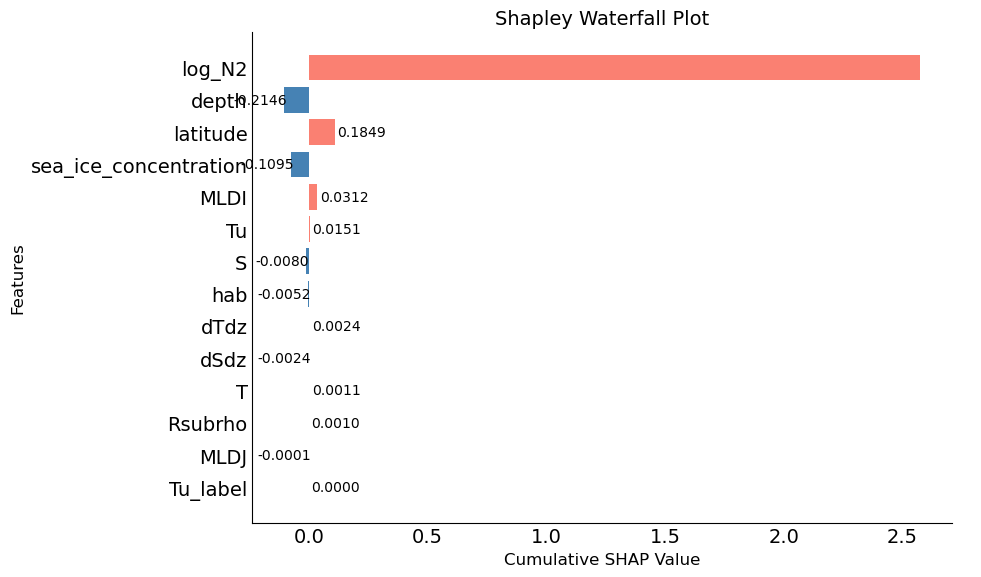

In [19]:
plot_shap_waterfall(X_test, shap_values, 4601)

## Waterfall plots

In [ ]:
shap.plots.waterfall(shap_values[0])

## Local force plots

In [92]:
import shap
import matplotlib.pyplot as plt

def plot_shap_force(X_test, shap_values, instance_idx):
    """
    Generate a SHAP force plot for a specific instance.

    Parameters:
        X_test (pd.DataFrame): Input features.
        shap_values (np.ndarray or list): SHAP values for the instance.
        instance_idx (int): Index of the instance in the test/validation set.

    Returns:
        None

    """
    # Select the instance for the force plot
    instance = X_test.iloc[instance_idx]
    print(pd.DataFrame(instance))

    # Initialize the SHAP explainer
    explainer = shap.Explainer(model)
    
    # Calculate the expected value
    expected_value = explainer.expected_value

    # Generate the SHAP force plot
    shap.force_plot(expected_value, shap_values[instance_idx], instance)
    
    # Display the plot
    shap.initjs()
    plt.show()

# Call the function to generate the SHAP force plot
plot_shap_force(X_test, shap_values, 0)


                            557861
depth                   331.000000
hab                   -3029.000000
S                        34.826559
T                         1.226168
dSdz                      0.001670
dTdz                      0.004732
log_N2                   -5.436758
Tu_label                 10.000000
MLDJ                      1.000000
MLDI                      8.000000
Rsubrho                   0.004872
sea_ice_concentration     0.990000
latitude                 87.448887
Tu                      -45.279167


In [85]:
# Predict on the test set
y_pred = model.predict(X_test)

In [86]:
# Reshape y_pred
y_pred = np.reshape(y_pred, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(Y_test, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)
#plot_residuals(arctic_all_testdf)

#merged_df_SIC = SIC_all_testdf.merge(arctic_df, on=xstringlist_all_SIC+ystringlist_all_SIC)
#merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all_SIC+ystringlist_all_SIC)
#residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])

In [88]:
explainer.expected_value

-10.324895

In [87]:
## Local analysis
obs_idx = 2
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)

KeyError: 2

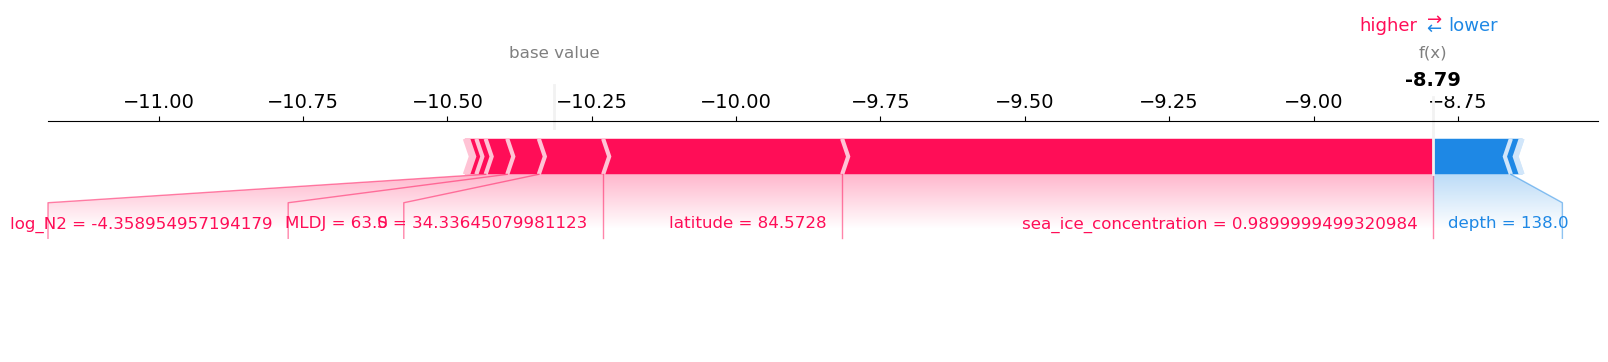

In [26]:
## Local analysis
obs_idx = 20000
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)

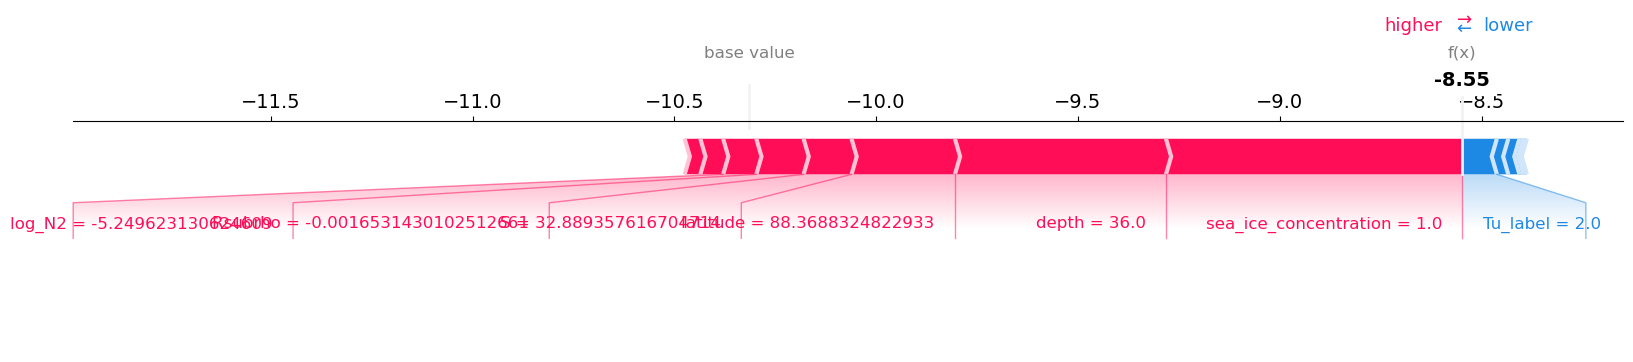

In [24]:
## Local analysis
obs_idx = 1000
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)

In [7]:
arctic_df

,depth,profile,cruise,latitude,longitude,S,T,log_eps,log_N2,dTdz,dSdz,hab,Tu,Tu_label,Rsubrho,sea_ice_concentration,MLDJ,MLDI,time
1177,2.0,1102.000,NICE-2015,83.002299,19.961173,34.200404,-1.885862,-6.298421,-6.575730,0.000049,-0.000295,-3358.0,-39.044222,Doubly stable,-0.104324,0.96,55.0,121.0,2015-01-25 12:35:31.000008448
1178,2.0,1103.000,NICE-2015,83.033071,19.347037,34.204764,-1.883707,-5.993973,-5.869163,0.000038,-0.000034,-3358.0,-45.923001,Diffusive Convection,0.016111,0.96,0.0,9.0,2015-01-26 07:28:30.000005376
1180,2.0,1105.000,NICE-2015,83.033789,19.332404,34.229158,-1.880199,-6.089278,-6.471863,0.000078,-0.000037,-3358.0,-50.385671,Diffusive Convection,0.094276,0.96,0.0,90.0,2015-01-26 07:55:23.000007168
1181,2.0,1106.000,NICE-2015,83.034314,19.321374,34.226959,-1.882910,-5.959098,-5.585578,0.000136,0.000136,-3358.0,-44.747959,Doubly stable,-0.004399,0.96,57.0,82.0,2015-01-26 08:14:57.000006144
1182,2.0,1107.000,NICE-2015,83.061026,18.517843,34.216128,-1.881480,-6.425529,-5.763924,0.000082,0.000211,-3358.0,-45.141667,Diffusive Convection,0.002473,0.96,64.0,99.0,2015-01-27 08:07:11.000009216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168963,490.0,241.665,ASCOS,87.286000,-9.409000,34.856000,0.762000,-9.175009,-5.536014,-0.006000,0.000000,-2870.0,-44.682134,Doubly stable,-0.005548,0.93,30.0,292.0,2008-08-28 15:57:36.000000000
168984,490.0,242.442,ASCOS,87.248000,-9.534000,34.856000,0.754000,-9.339394,-5.163739,-0.006500,-0.000500,-2870.0,-33.694683,Doubly stable,-0.199916,0.94,24.0,343.0,2008-08-29 10:36:28.800000000
168985,490.0,242.467,ASCOS,87.247000,-9.524000,34.856000,0.775000,-9.344900,-5.115228,-0.001000,0.000000,-2870.0,-23.401593,Doubly stable,-0.395896,0.94,0.0,299.0,2008-08-29 11:12:28.800000000
168999,490.0,242.976,ASCOS,87.235000,-9.368000,34.856000,0.765000,-9.013347,-5.114903,0.002500,0.001000,-2870.0,-55.729990,Diffusive Convection,0.189494,0.93,21.0,285.0,2008-08-29 23:25:26.400000000


In [15]:
# find out who this sexy thing is
import pandas as pd

# Filter the dataframe based on depth and latitude
filtered_df = arctic_df[(arctic_df['depth'] == 36) & (arctic_df['latitude'] == 88.3688324822933)]
filtered_df

,depth,profile,cruise,latitude,longitude,S,T,log_eps,log_N2,dTdz,dSdz,hab,Tu,Tu_label,Rsubrho,sea_ice_concentration,MLDJ,MLDI,time
29156,36.0,56.0,IPY Barneo 2008,88.368832,4.070574,32.889358,-1.798118,-8.322612,-5.249623,0.000014,0.000208,-3324.0,-44.905282,Doubly stable,-0.001653,1.0,0.0,3.0,2008-04-20 17:43:27.999999448


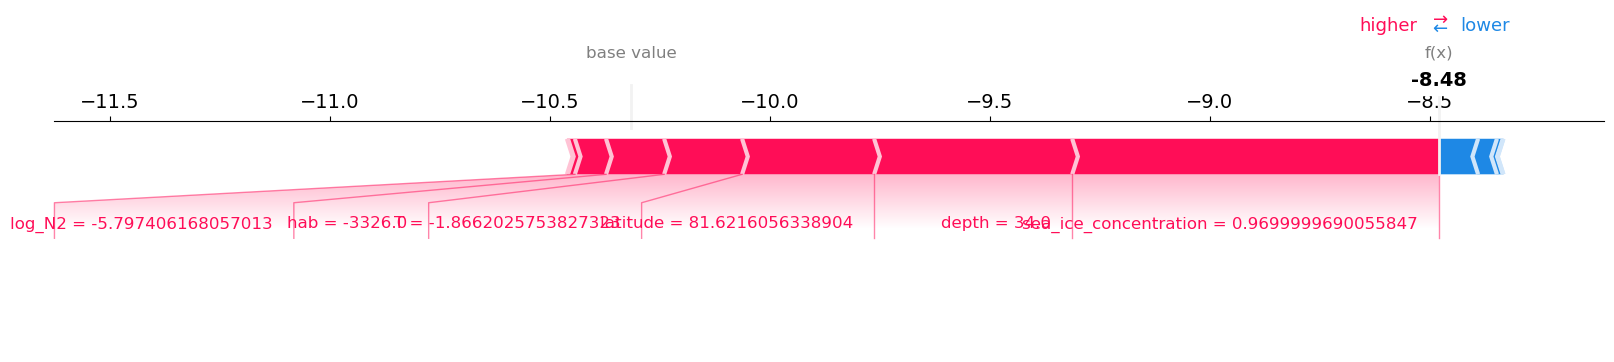

In [23]:
## Local analysis
obs_idx = 1
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)

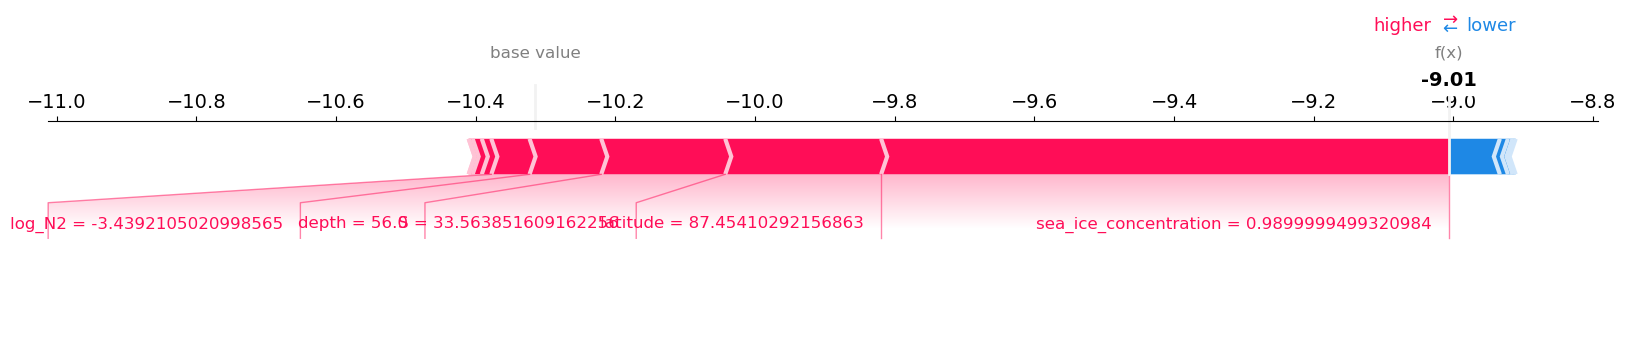

In [25]:
## Local analysis
obs_idx = 488
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)
#plt.savefig("plots/force_plot.png")

In [32]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [33]:
# Assign feature names to the shap_values object
shap_values.feature_names = xstringlist_all_SIC

The heatmap plot produced by shap.plots.heatmap() displays the SHAP values as a color-coded grid, where each row represents an instance, and each column represents a feature. The color of each cell in the grid represents the magnitude and direction of the SHAP value for a particular feature and instance.

The key aspects of interpreting the heatmap plot are as follows:

Color Intensity: The color intensity of a cell represents the magnitude of the SHAP value for a feature in an instance. Darker colors indicate higher positive or negative SHAP values, indicating a stronger influence of that feature on the model prediction.

Color Scale: The color scale or color bar displayed alongside the heatmap indicates the corresponding SHAP value range. It helps to interpret the intensity of the colors in the plot.

Feature Order: The columns in the heatmap correspond to the features, and their order matches the order of the features in the dataset. Each column represents the SHAP values for a specific feature across all instances.

Instance Order: The rows in the heatmap represent the instances, and their order corresponds to the order of instances in the input data. Each row shows the SHAP values for all features of a specific instance.

The heatmap plot allows you to identify the relative importance and impact of different features on model predictions across multiple instances. By observing patterns and color distributions in the heatmap, you can gain insights into how different features contribute to the model's output and understand their influence on individual predictions.

In [36]:
shap.plots.heatmap(shap_values[:10000])

## Shap values per region

 Extract values from the 12th column of batch 1
batch_1 = X_train[(X_train[:, 12] > 60) & (X_train[:, 12] <= 75)]
batch_2 = X_train[(X_train[:, 12] > 75) & (X_train[:, 12] <= 81)]
batch_3 = X_train[(X_train[:, 12] > 81) & (X_train[:, 12] <= 90)]

In [62]:
batch_1 = X_train.loc[(X_train.iloc[:, 12] > 60) & (X_train.iloc[:, 12] <= 75)]
batch_2 = X_train.loc[(X_train.iloc[:, 12] > 75) & (X_train.iloc[:, 12] <= 81)]
batch_3 = X_train.loc[(X_train.iloc[:, 12] > 81) & (X_train.iloc[:, 12] <= 90)]

In [63]:
len(batch_1)

61326

In [64]:
len(batch_2)

64382

In [65]:
len(batch_3)

467682

In [66]:
# Fit relevant explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
# View shap values
print(shap_values)

[[-1.25223801e-01 -2.76528508e-03 -1.26590794e-02 ...  3.48282270e-02
  -8.45213681e-02  3.61712482e-05]
 [-1.31445006e-01 -2.40752124e-03 -2.32193004e-02 ...  8.28955397e-02
   1.19899295e-01  4.29820175e-05]
 [-1.17138475e-01 -2.82459287e-03 -1.05302716e-02 ...  3.33688483e-02
   5.40436059e-02  3.61712482e-05]
 ...
 [-3.24858189e-01 -4.34613507e-03  7.92691186e-02 ... -2.06911847e-01
   9.68679041e-02  1.72121145e-05]
 [-7.37324059e-02 -3.24719795e-03 -5.96756436e-05 ...  4.51891497e-03
  -7.99417347e-02  3.70670896e-05]
 [-2.54206598e-01 -1.36845103e-02  8.12880918e-02 ... -1.74474761e-01
   1.08912200e-01  1.64885387e-05]]


In [67]:
# Compute Shapley values for each batch
explainer = shap.TreeExplainer(model)
shap_values_batch1 = explainer.shap_values(batch_1)
shap_values_batch2 = explainer.shap_values(batch_2)
shap_values_batch3 = explainer.shap_values(batch_3)

# Normalize the Shapley values within each batch
shap_values_batch1_normalized = (shap_values_batch1 - shap_values_batch1.mean()) / shap_values_batch1.std()
shap_values_batch2_normalized = (shap_values_batch2 - shap_values_batch2.mean()) / shap_values_batch2.std()
shap_values_batch3_normalized = (shap_values_batch3 - shap_values_batch3.mean()) / shap_values_batch3.std()


In [68]:

xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']
ystringlist_all_SIC = ['log_eps']


# Convert Shapley values to DataFrames
shap_values_batch1_df = pd.DataFrame(shap_values_batch1_normalized, columns=xstringlist_all_SIC)
shap_values_batch2_df = pd.DataFrame(shap_values_batch2_normalized, columns=xstringlist_all_SIC)
shap_values_batch3_df = pd.DataFrame(shap_values_batch3_normalized, columns=xstringlist_all_SIC)

<Figure size 1000x600 with 0 Axes>

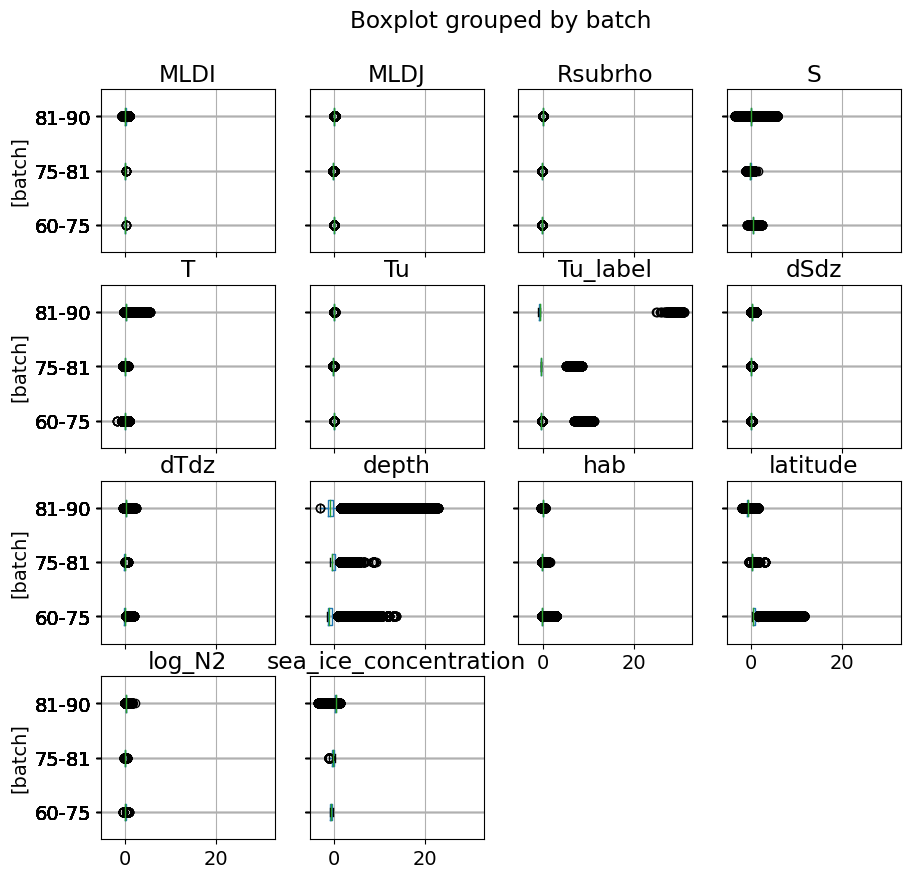

In [69]:
# Add 'batch' column to each DataFrame
shap_values_batch1_df['batch'] = '60-75'
shap_values_batch2_df['batch'] = '75-81'
shap_values_batch3_df['batch'] = '81-90'

# Concatenate the normalized Shapley values for comparison
shap_values_combined = pd.concat([shap_values_batch1_df, shap_values_batch2_df, shap_values_batch3_df])

# Plot box plots to compare Shapley values across batches
plt.figure(figsize=(10, 6))
shap_values_combined.boxplot(by="batch", vert=False)
plt.title("Comparison of Shapley Values across Batches")
plt.xlabel("Shapley Value")
plt.ylabel("Batch")
plt.show()

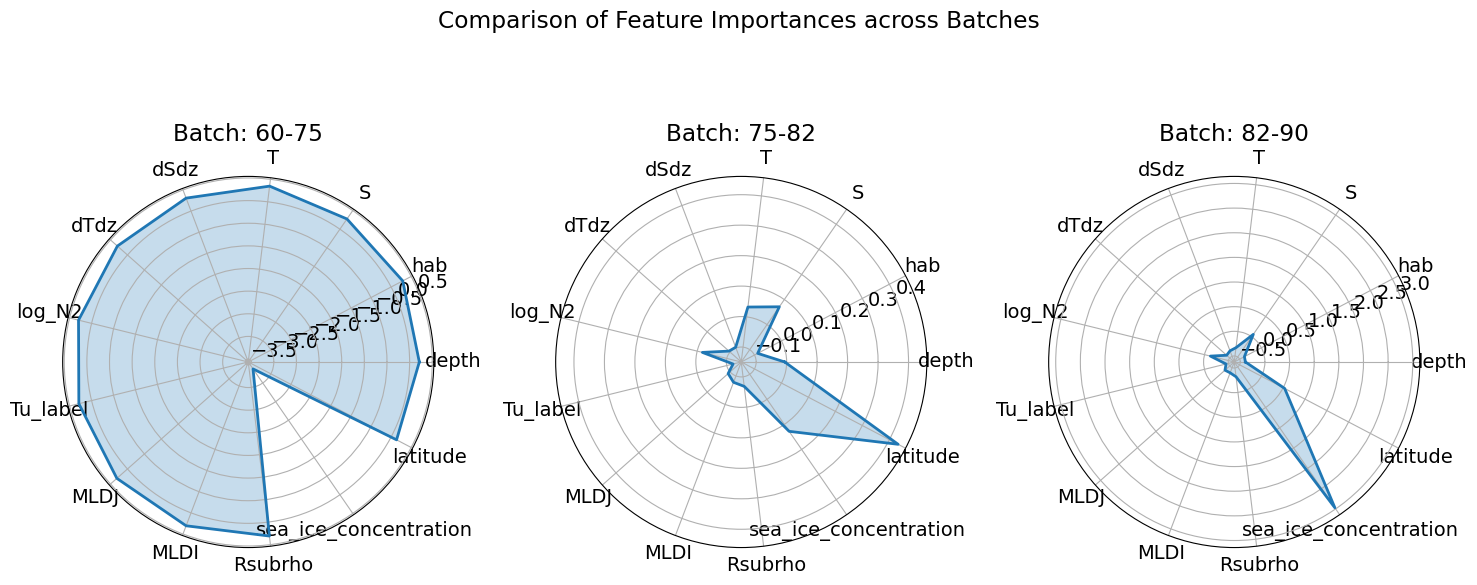

In [ ]:
# Define the features
features = shap_values_combined.columns[:-1]  # Exclude 'batch' column

# Plot radar charts for each batch
num_batches = shap_values_combined['batch'].nunique()
fig, axs = plt.subplots(nrows=1, ncols=num_batches, figsize=(15, 6), subplot_kw=dict(polar=True))

for i, (batch, ax) in enumerate(zip(shap_values_combined['batch'].unique(), axs.flatten())):
    batch_values = shap_values_combined.loc[shap_values_combined['batch'] == batch, features].mean().values
    values = np.concatenate((batch_values, [batch_values[0]]))
    angles = np.linspace(0, 2 * np.pi, len(features) + 1, endpoint=True)

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title(f'Batch: {batch}')

plt.suptitle("Comparison of Feature Importances across Batches", y=1.05)
plt.tight_layout()
plt.show()


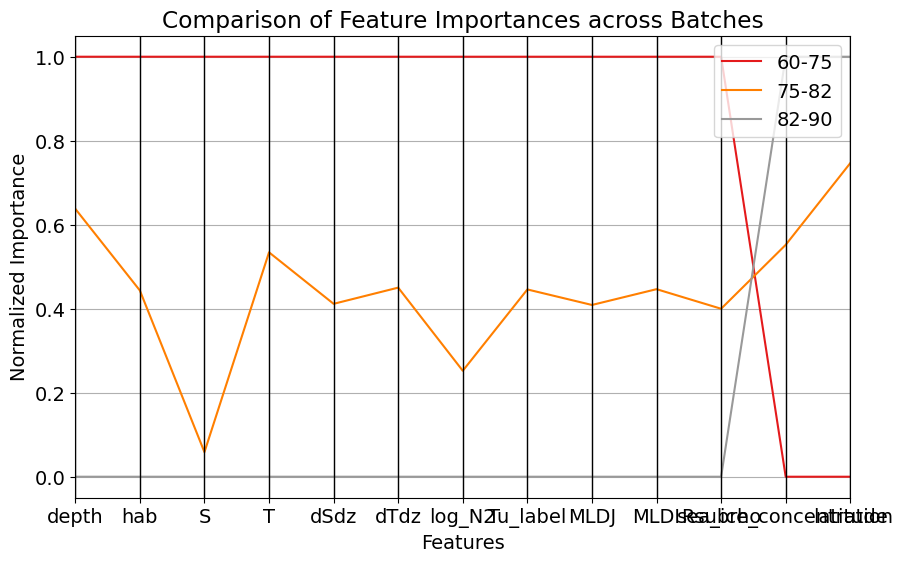

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates

# Group the Shapley values by batch and calculate the mean for each feature
average_feature_importances = shap_values_combined.groupby(['batch']).mean().reset_index()

# Remove the 'batch' column from the DataFrame
average_feature_importances = average_feature_importances.drop('batch', axis=1)

# Normalize the feature importances for each batch
normalized_feature_importances = (average_feature_importances - average_feature_importances.min()) / (
        average_feature_importances.max() - average_feature_importances.min())

# Add the 'batch' column back to the normalized DataFrame
normalized_feature_importances['batch'] = ['60-75', '75-81', '81-90']

# Set the 'batch' column as the first column
cols = normalized_feature_importances.columns.tolist()
cols = cols[-1:] + cols[:-1]
normalized_feature_importances = normalized_feature_importances[cols]

# Create the parallel coordinate plot
plt.figure(figsize=(10, 6))
parallel_coordinates(normalized_feature_importances, 'batch', colormap='Set1')

# Set the title and labels
plt.title('Comparison of Feature Importances across Batches')
plt.xlabel('Features')
plt.ylabel('Normalized Importance')

# Show the plot
plt.show()



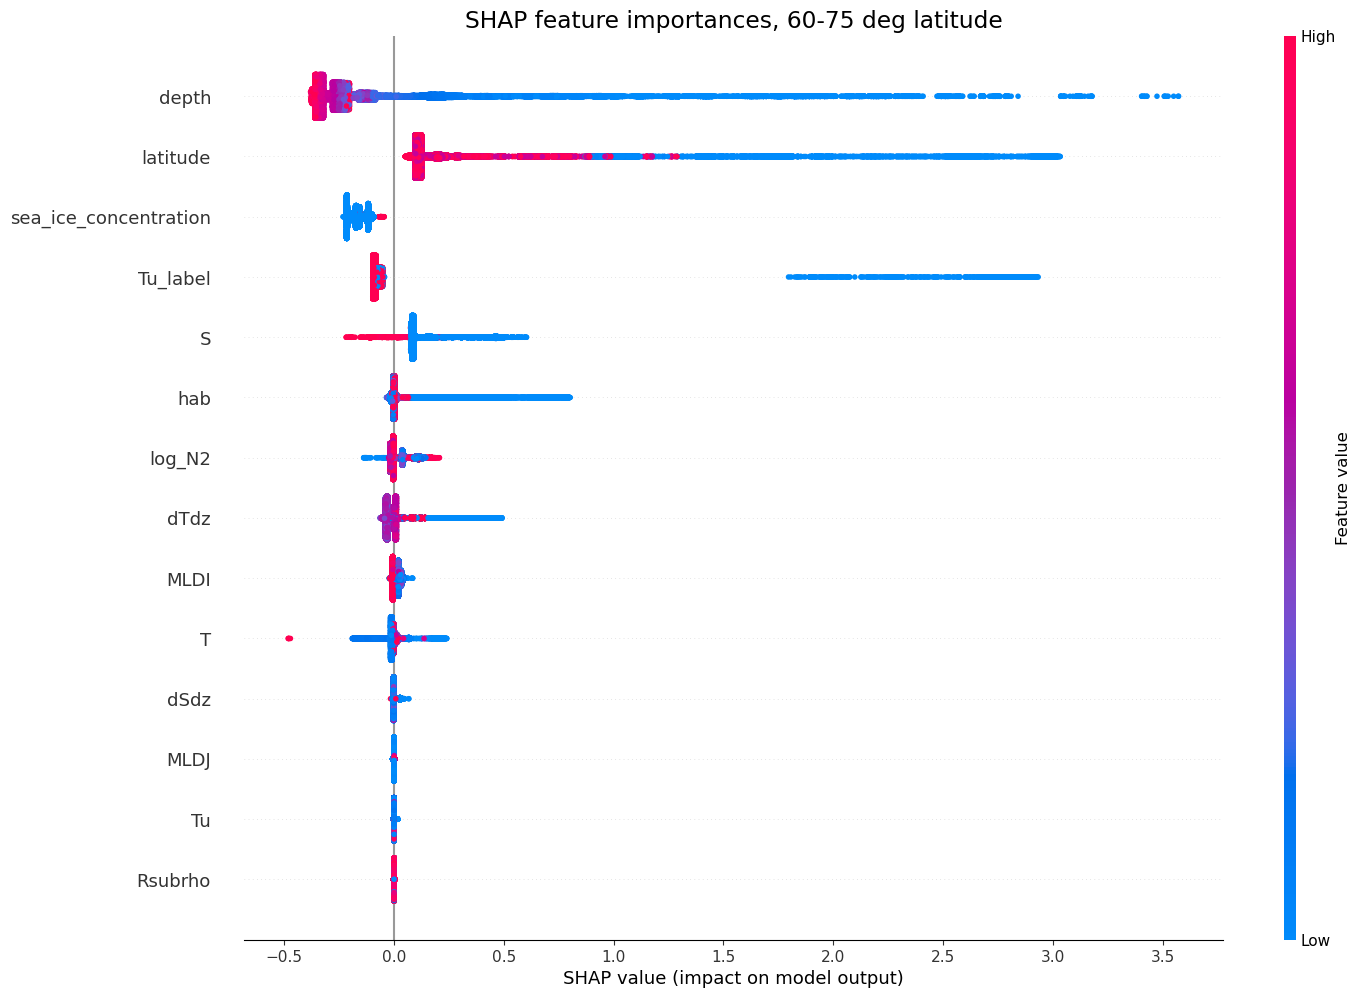

In [70]:
plt_shap = shap.summary_plot(shap_values_batch1, #Use Shap values array
                             features=batch_1, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

plt.title("SHAP feature importances, 60-75 deg latitude")

# Save my figure to a directory
plt.savefig("plots/batch1_shap.png")

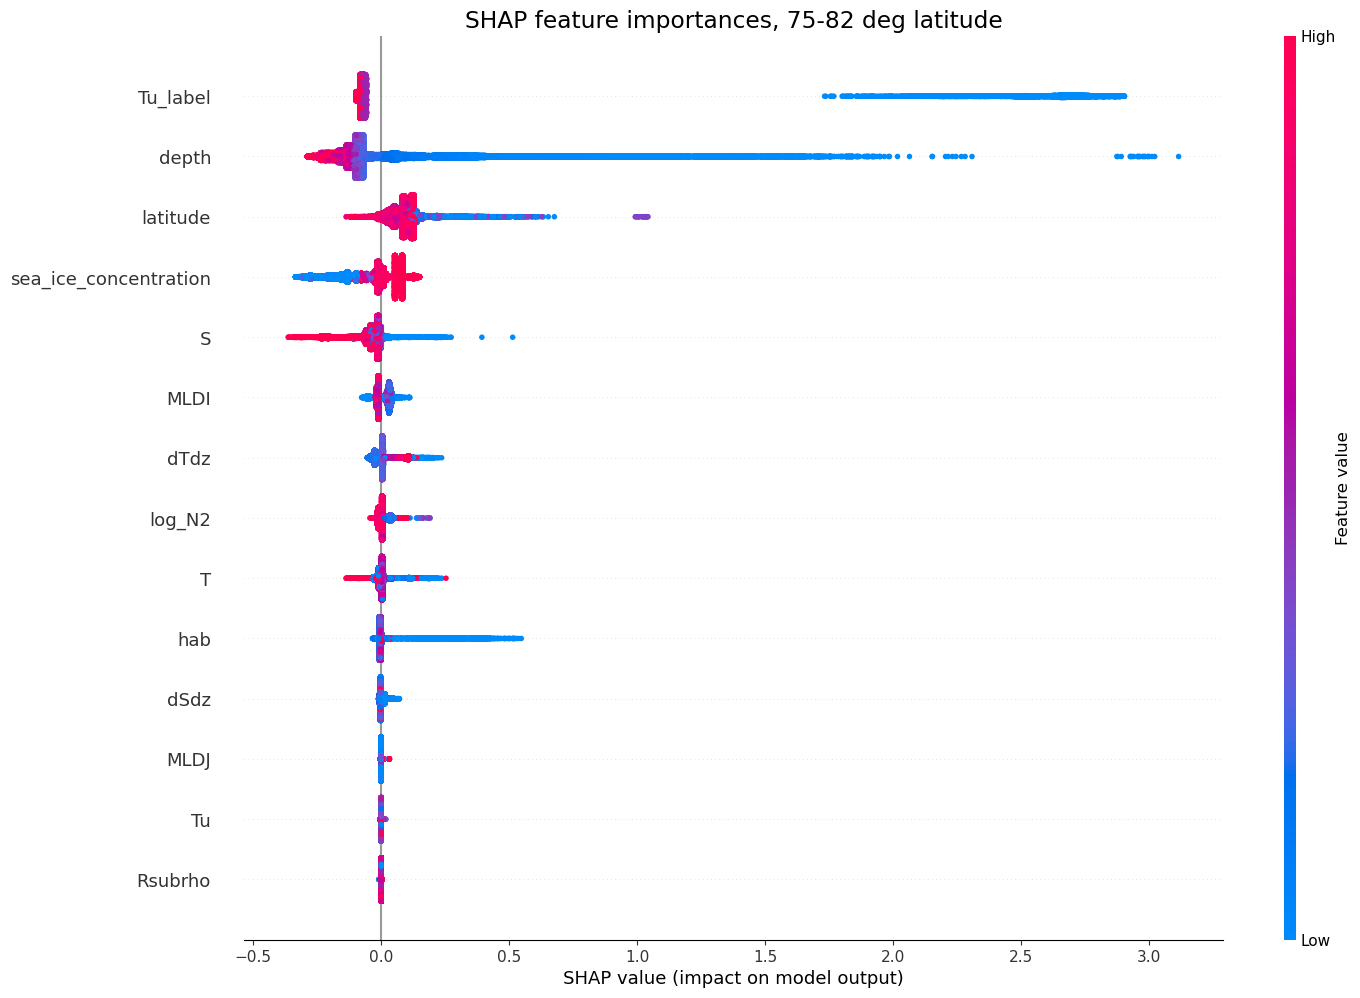

In [71]:
plt_shap = shap.summary_plot(shap_values_batch2, #Use Shap values array
                             features=batch_2, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

plt.title("SHAP feature importances, 75-82 deg latitude")

# Save my figure to a directory
plt.savefig("plots/batch2_shap.png")

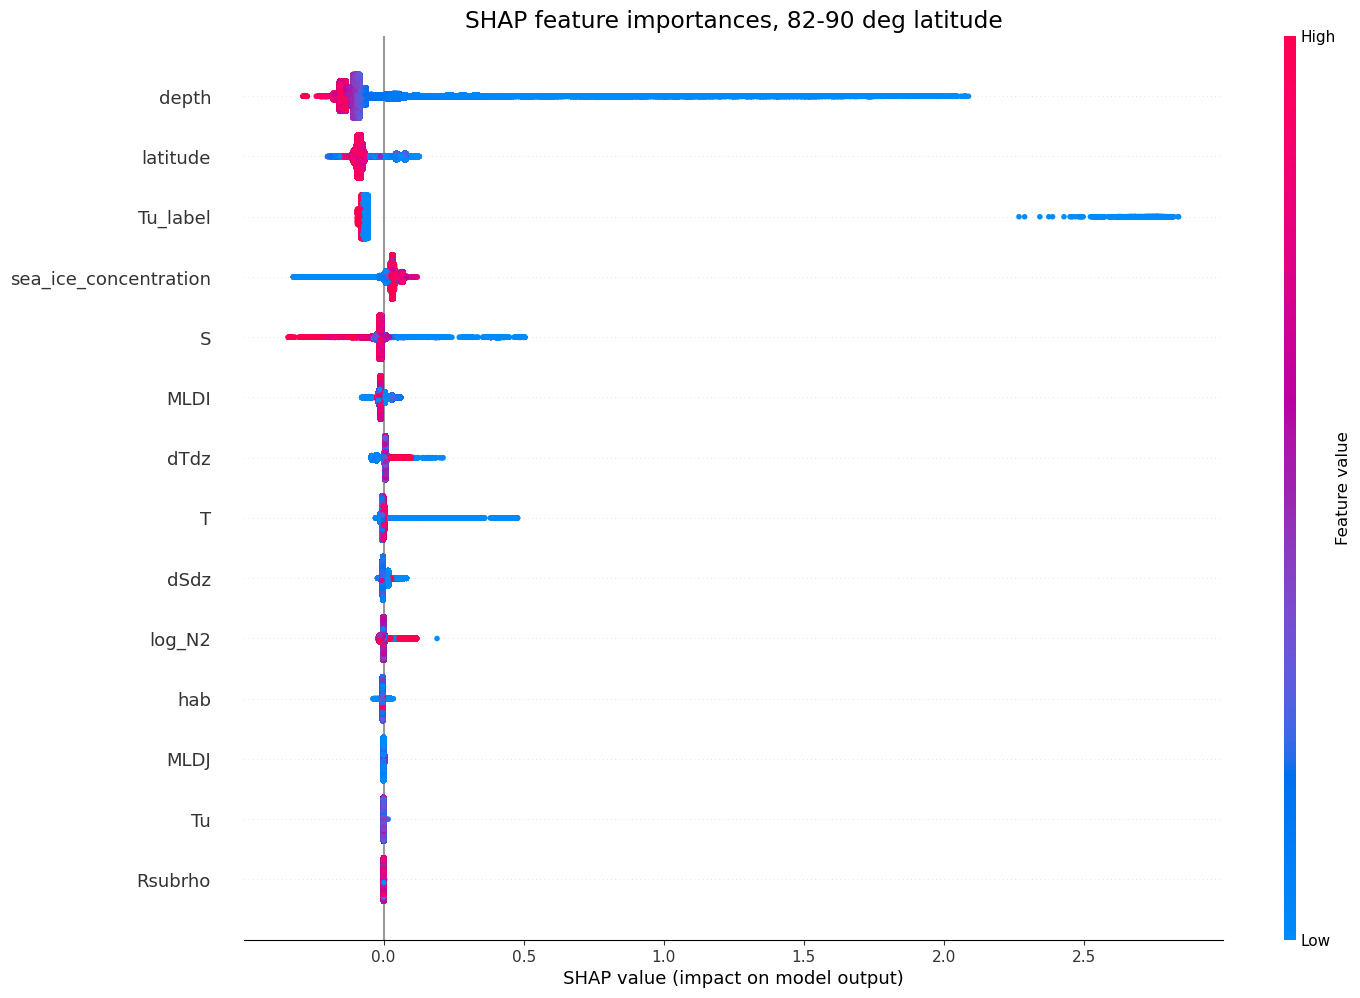

In [72]:

plt_shap = shap.summary_plot(shap_values_batch3, #Use Shap values array
                             features=batch_3, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size
plt.title("SHAP feature importances, 82-90 deg latitude")
# Save my figure to a directory
plt.savefig("plots/batch3_shap.png")


The Shapley summary plot is a visualization that provides an overview of the feature importance based on the Shapley values. It helps in understanding how each feature contributes to the model's output and their relative importance.

In a Shapley summary plot, the features are sorted in descending order based on their average absolute Shapley values. The plot consists of horizontal bars representing each feature, with the length of the bar indicating the magnitude of the feature's average Shapley value. The bars are color-coded based on the sign of the Shapley value, where positive values are displayed in blue and negative values in red.

Here's how to interpret a Shapley summary plot:

Feature Importance: The vertical axis represents the features. Features at the top have higher average absolute Shapley values and contribute more to the model's output.

Shapley Value Magnitude: The horizontal axis represents the average absolute Shapley values. The longer the bar for a feature, the more it influences the model's predictions. Features with longer bars are considered more important.

Sign of Shapley Values: The color of the bars indicates the sign of the Shapley values. Blue bars represent positive Shapley values, indicating that the feature positively contributes to the prediction. Red bars represent negative Shapley values, indicating a negative contribution to the prediction.

Comparative Analysis: By comparing the lengths of the bars, you can identify the most influential features. Longer bars indicate stronger contributions, while shorter bars have relatively lesser impact.

Interaction Effects: If two features are close to each other and have similar lengths, it suggests they may interact with each other to influence the predictions.

### shapley test for depth

In [26]:
# Extract values from the 12th column of batch 1
batch_1 = X_train[(X_train[:, 0] > 0 ) & (X_train[:, 0] <= 100)]
batch_2 = X_train[(X_train[:, 0] > 100) & (X_train[:, 12] <= 2000)]

In [27]:
# Compute Shapley values for each batch
explainer = shap.TreeExplainer(model)
shap_values_batch1 = explainer.shap_values(batch_1)
shap_values_batch2 = explainer.shap_values(batch_2)

# Normalize the Shapley values within each batch
shap_values_batch1_normalized = (shap_values_batch1 - shap_values_batch1.mean()) / shap_values_batch1.std()
shap_values_batch2_normalized = (shap_values_batch2 - shap_values_batch2.mean()) / shap_values_batch2.std()

# Convert Shapley values to DataFrames
shap_values_batch1_df = pd.DataFrame(shap_values_batch1_normalized, columns=xstringlist_all_SIC)
shap_values_batch2_df = pd.DataFrame(shap_values_batch2_normalized, columns=xstringlist_all_SIC)

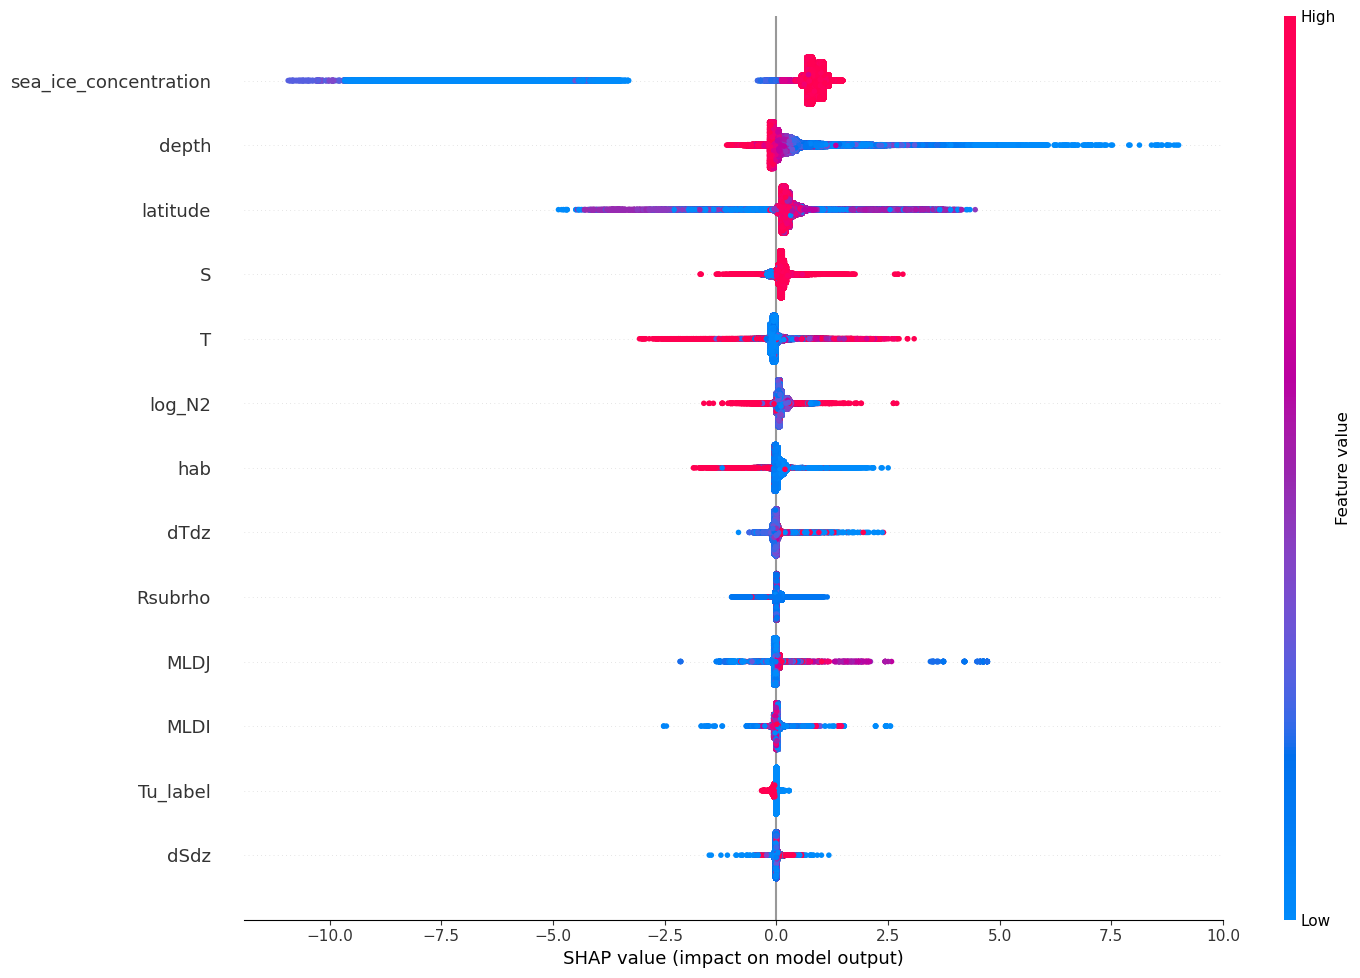

In [29]:
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

plt_shap = shap.summary_plot(shap_values_batch1, #Use Shap values array
                             features=batch_1, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

# Save my figure to a directory
plt.savefig("plots/batch1_depth_shap.png")

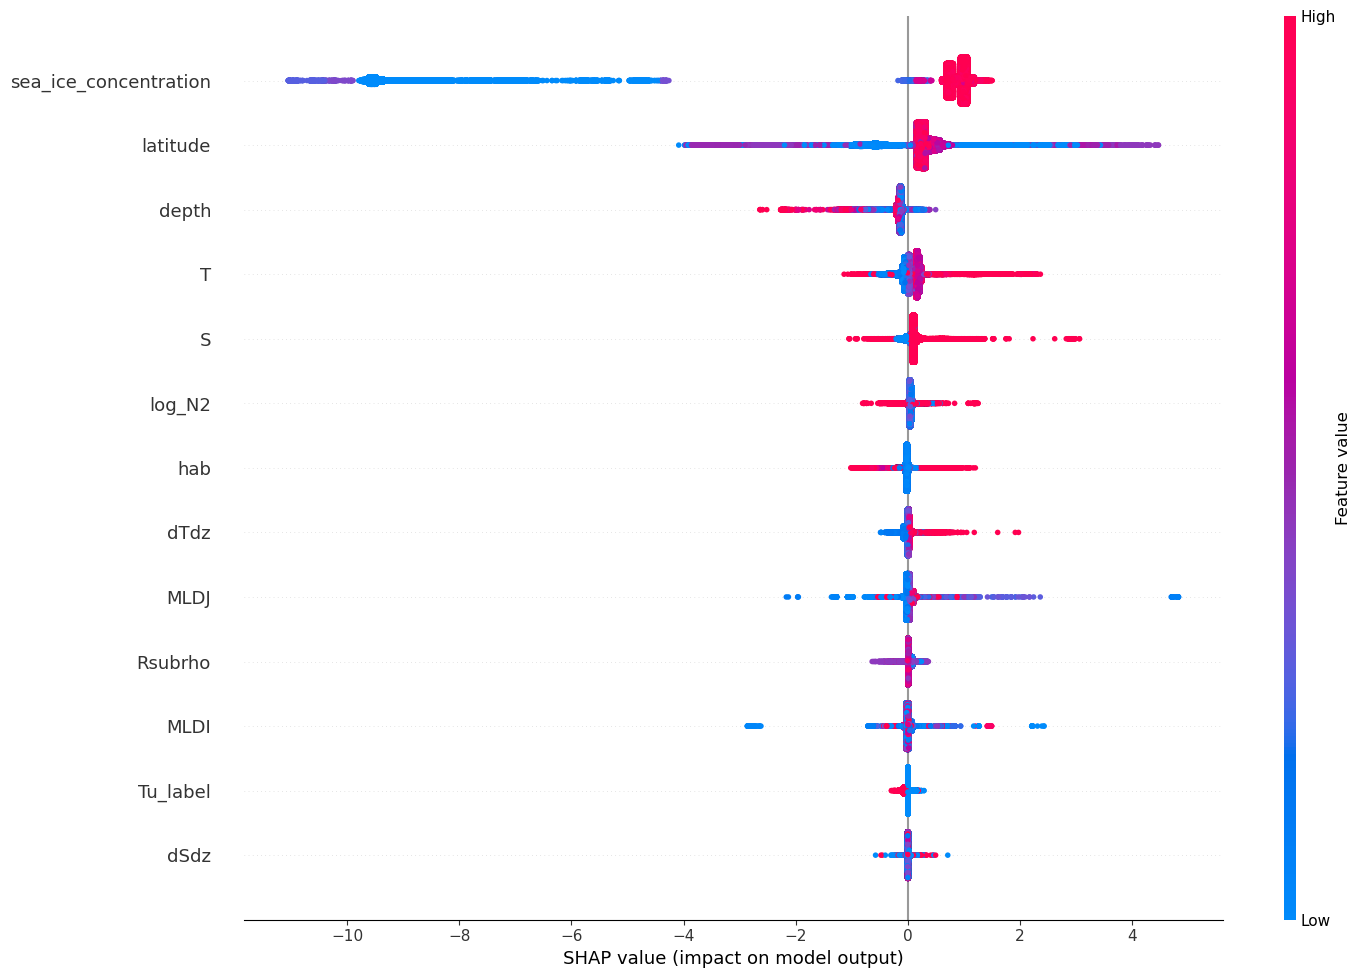

In [28]:
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

plt_shap = shap.summary_plot(shap_values_batch2, #Use Shap values array
                             features=batch_2, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

# Save my figure to a directory
plt.savefig("plots/batch2_depth_shap.png")